### Step 1 : Set image folder.

In [1]:
# 👇 Use your own image folder path.
image_folder_path = '../images'

### Step 2 : Pre-process images.

In [2]:
import os
import base64
from collections import namedtuple

ImageData = namedtuple('ImageData', 'filename_without_extension extension base64_string')

def convert_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

def get_file_type(filename):
    return os.path.splitext(filename)[1][1:]  # get file extension without dot

def get_filename_without_extension(filename):
    return os.path.splitext(filename)[0]  # get filename without extension

def convert_images_in_folder(folder_path):
    image_datas = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            file_path = os.path.join(folder_path, filename)
            base64_string = convert_image_to_base64(file_path)
            file_type = get_file_type(filename)
            filename_without_extension = get_filename_without_extension(filename)
            image_datas.append(ImageData(filename_without_extension, file_type, base64_string))
    return image_datas

image_datas = convert_images_in_folder(image_folder_path)

# 🐞 uncomment to debug
# for item in base64_images:
#     print(item[0], item[1], item[2], item[3])

if len(image_datas) > 300:
    image_datas = []
    print('❌ Too many images. Max 300 images allowed.')

print(f'✅ {len(image_datas)} image(s) processed.')

2 image(s) processed.


### Step 3 : Call Azure OpenAI services.

❗️❗️ Don't foget to config your Azure OpenAI key:
- Add `AZURE_OPENAI_API_KEY={your_azure_openai_key_here}` to `.env` file;
- If it doesn't exist, create one in this project root folder.

In [6]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os
import re

load_dotenv()

client = AzureOpenAI(
    # https://learn.microsoft.com/en-us/azure/ai-services/openai/reference#rest-api-versioning
    api_version="2023-07-01-preview",
    # https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#create-a-resource
    azure_endpoint="https://openai-ifbox-ai.openai.azure.com",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

ImageCaption = namedtuple('ImageCaption', 'filename_without_extension caption')


# Call GPT-4 Vision to generate image captions if the number of images is less than 300 incase of too many requests.
if 0 < len(image_datas) <= 300:
  image_captions = []
  for item in image_datas:
    completion = client.chat.completions.create(
      model = "gpt-4-vision-preview",  # Your deployment name.
      max_tokens = 500,
      messages = [
        {
          "role": "system",
          
          "content": 
          # Edit this system message if needed.
          """
          You are going to help people to describe the image.
          You should always in english start with "the image is showing"      
          """
        },
        {
          "role": "user",
          "content": [
            {
              "type": "image_url",
              "image_url": { 
                "url": f"data:image/{item.extension};base64,{item.base64_string}",
                "detail": "low",},
              
            }],
        }],
    )
    
    caption = re.sub("^the image is showing ", "", completion.choices[0].message.content, flags=re.IGNORECASE)
    image_caption = ImageCaption(item.filename_without_extension, caption)
    image_captions.append(image_caption)
    print(image_caption.caption)

  image_chinese_captions = []
  for item in image_captions:
    completion = client.chat.completions.create(
      model = "gpt-35-turbo",  # Your deployment name.
      max_tokens = 500,
      messages = [
        {
          "role": "system",
          
          "content": 
          # Edit this system message if needed.
          """
          你是一个翻译助手，能够把英文翻译成中文。你收到一段英文后，请直接翻译成中文。   
          """
        },
        {
          "role": "user",
          "content": item.caption,
        }],
    )

    caption_to_chinese = completion.choices[0].message.content
    image_chinese_caption = ImageCaption(item.filename_without_extension, caption_to_chinese)
    image_chinese_captions.append(image_chinese_caption)
    print(image_chinese_caption.caption)

if len(image_captions) > 0:
  print(f'✅ Generate {len(image_captions)} caption(s).')
else:
  print('❌ No image processed.')

a graphic with the word "IFBOX" in capital letters, with the "IF" in black font and "BOX" in a lighter shade, possibly gray. To the left of the text, there is a rectangular icon with a neon blue and purple gradient outline, resembling a screen or a box. The background of the image is white.
a futuristic scene with a large aircraft in the foreground, featuring a prominent nose and two people standing nearby, seemingly looking at it. The background is dominated by a massive, industrial-looking structure with a variety of architectural details and lighting, possibly a spaceport or hangar. The atmosphere has a moody, dramatic tone with a large sun or moon visible in the sky, casting a glare that interacts with the mist or haze in the air. There is also a smaller vehicle to the right of the people for scale, conveying a sense of grandeur and awe. The art style appears to be digital painting, with a focus on dramatic lighting and a warm color palette.
图中有大写字母“IFBOX”，“IF”部分为黑色字体，“BOX”部分为浅色，可能

### Step 4 : Save txt.

In [4]:
# Set to True to overwrite existing files.
force_rewrite = True

def save_text_to_file(text, file_path):
    # 检查文件是否存在
    if os.path.exists(file_path) and not force_rewrite:
        raise FileExistsError(f"❌ File already exists: {file_path}")
    
    # 如果目录不存在，则创建目录
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # 将文本写入文件
    with open(file_path, 'w') as file:
        file.write(text)
        
count = 0
for item in image_captions:
    file_path = f'{image_folder_path}/{item.filename_without_extension}.txt'
    try:
        save_text_to_file(item.caption, file_path)
        count += 1
    except FileExistsError as e:
        print(e)
        continue

if count != 0:
    print(f'✅ {count} caption file(s) saved.')

count = 0
for item in image_chinese_captions:
    file_path = f'{image_folder_path}/chinese_captions/{item.filename_without_extension}_chinese.txt'
    try:
        save_text_to_file(item.caption, file_path)
        count += 1
    except FileExistsError as e:
        print(e)
        continue

if count != 0:
    print(f'✅ {count} chinese caption file(s) saved.')

✅ 2 caption file(s) saved.
✅ 2 chinese caption file(s) saved.


### Step 5 : Humun review.

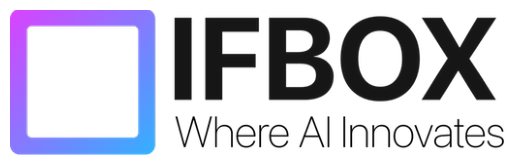

logo.png
a logo with the word "IFBOX" written in uppercase letters with a gradient effect of purple and blue shades. To the left of the text, there is a stylized design resembling a square or box with a similar gradient color scheme and a black area that could represent an empty space or opening. The overall design has a modern and digital feel.
一个标志，上面用大写字母写着“IFBOX”，并采用紫色和蓝色渐变效果。在文本的左侧，有一个样式设计，类似一个正方形或盒子，采用相似的渐变色，并有一个黑色区域，可以代表一个空白空间或开口。整体设计具有现代和数字化的感觉。


------------------------------------


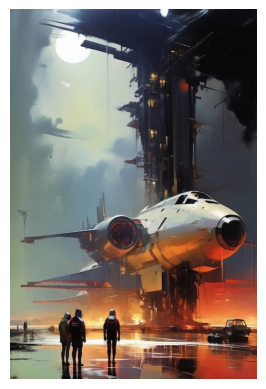

ship.jpeg
an atmospheric scene with two individuals standing in the foreground, looking towards a large, futuristic aircraft. The aircraft appears to be parked on a platform, with its high-tech architecture and engines prominently displayed. The environment suggests a sci-fi setting with a vast, industrial structure in the background and a hazy, orange-tinted sky that might indicate either sunset or the ambient light of a densely populated, industrial planet. There is a feeling of anticipation or arrival, as the figures seem to be either awaiting departure or have just arrived. A smaller vehicle is also visible to the right, adding to the sense of scale and activity in the scene.
一幅氛围独特的场景，两个人站在前景，朝着一架巨大的未来飞行器望去。这架飞行器似乎停在一个平台上，高科技的建筑和引擎显眼地展示着。环境暗示着一个科幻设置，背景中有一个庞大的工业建筑结构，天空呈现出一片朦胧的橙色，似乎暗示着夕阳或者是人口密集的工业星球的环境光。场景中充满着期待和到达的感觉，这两个人似乎要么正在等待起飞，要么刚刚抵达。右侧还能看到一辆小型车，增强了场景中的尺度感和活动感。


------------------------------------


In [5]:
import matplotlib.pyplot as plt
from PIL import Image

if image_folder_path is None:
  # 👇 Use your own image folder path.
  image_folder_path = '../images'

# 获取目录下的所有文件
files = os.listdir(image_folder_path)

# 遍历文件列表
for file in files:

    file_extension = os.path.splitext(file)[1].lower()
    filename_without_extension = os.path.splitext(file)[0]

    # 检查文件名是否具有相同的前缀
    if file_extension in ('.png', '.jpg', '.jpeg', '.gif', '.bmp'):
        # 构建文本文件的路径
        file_extension_length = len(file_extension)
        caption_file = os.path.join(image_folder_path, filename_without_extension + '.txt')
        chinese_caption_file = os.path.join(image_folder_path, 'chinese_captions', filename_without_extension + '_chinese.txt')
        
        # 检查文本文件是否存在
        if os.path.isfile(caption_file):
            # 读取并显示照片
            img_path = os.path.join(image_folder_path, file)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            print(file)
            
            # 打开并显示文本文件的内容
            with open(caption_file, 'r') as f:
                text_content = f.read()
                print(text_content)
                # print('\n')
            with open(chinese_caption_file, 'r') as f:
                text_content = f.read()
                print(text_content)
            
            print('\n')
            print('------------------------------------')